In [1]:
import arviz as az
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
sys.path.append('./../figures/')
from makeCorner import *

First, load the output of our inference as an arviz InferenceData object:

In [2]:
data = az.from_netcdf("effective_spin_gaussian_spike_monteCarloAvg.cdf")
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bq,1.637,0.898,0.164,3.403,0.014,0.011,4811.0,3619.0,1.0
logit_zeta_spike,-0.753,1.122,-2.739,1.036,0.024,0.020,2835.0,2014.0,1.0
logsig_chi,-1.079,0.169,-1.423,-0.789,0.003,0.002,3115.0,2061.0,1.0
min_log_neff,1.748,0.459,0.899,2.538,0.008,0.006,3533.0,2829.0,1.0
mu_chi,0.091,0.035,0.030,0.157,0.001,0.000,3442.0,4424.0,1.0
nEff_inj_per_event,74.992,28.789,30.473,129.419,0.507,0.358,3366.0,5356.0,1.0
zeta_spike,0.361,0.182,0.000,0.637,0.003,0.002,2835.0,2014.0,1.0


The contents of this file are the following:

| Parameter | Description |
| :-------- | :---------- |
| `mu_chi` | Mean of the $\chi_\mathrm{eff}$ distribution |
| `logsig_chi` | Log10 of the standard deviation of the $\chi_\mathrm{eff}$ distribution |
| `zeta_spike` | Mixture of BBHs in the delta-function at $\chi_\mathrm{eff}=0$ |
| `logit_zeta_spike` | Intermediate parameter; for efficiency, our code samples in $\mathrm{logit}(\zeta_\mathrm{spike})$ rather than $\zeta_\mathrm{spike}$ itself |
| `bq` | Power-law index on the conditional secondary mass distribution $p(m_2\|m_1)$|
| `min_log_neff` | Log10 of the minimum number of effective samples (taken across events) for the proposed hyperparameter |
| `nEff_inj_per_event` | The effective number of found injections per observed event at the proposed hyperparameter (should be $\gg 4$) |

Next, plot our various chains to inspect convergence:

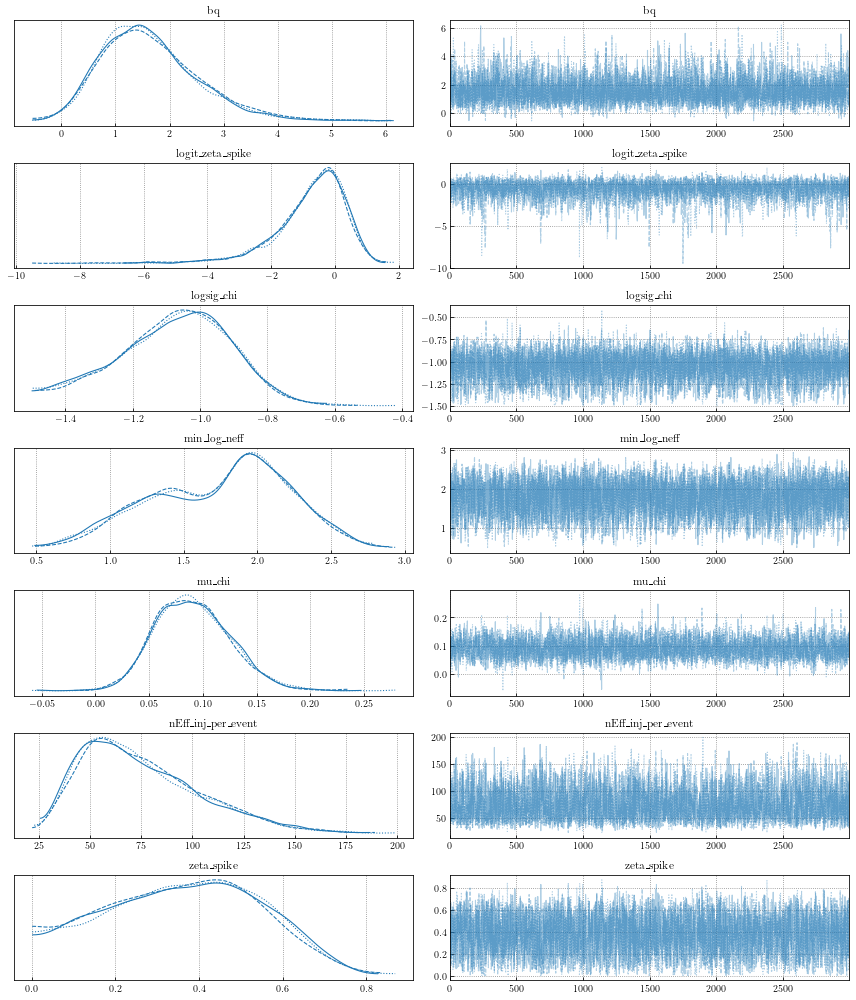

In [3]:
az.plot_trace(data, compact=True)
plt.tight_layout()
plt.show()

Let's make a corner plot showing posteriors on our parameters:

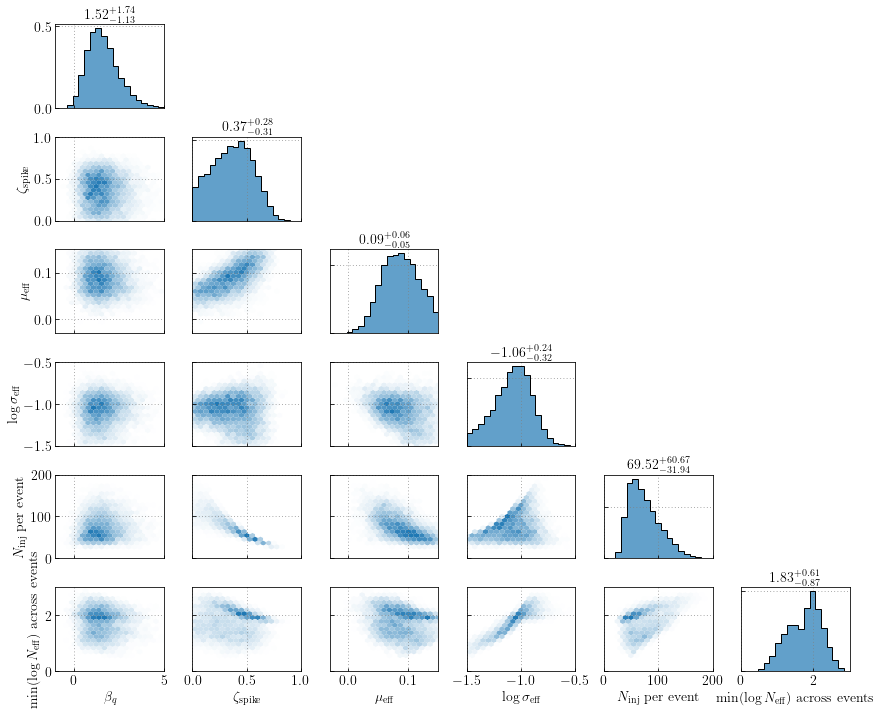

In [4]:
fig = plt.figure(figsize=(12,10))

stacked_samples = data.posterior.stack(draws=("chain", "draw"))
toPlot = {
    "bq":{"data":stacked_samples.bq,"plot_bounds":(-1,5),"label":r"$\beta_q$"},
    "zeta_spike":{"data":stacked_samples.zeta_spike,"plot_bounds":(0,1),"label":r"$\zeta_\mathrm{spike}$"},
    "mu_chi":{"data":stacked_samples.mu_chi,"plot_bounds":(-0.03,0.15),"label":r"$\mu_\mathrm{eff}$"},
    "logsig":{"data":stacked_samples.logsig_chi,"plot_bounds":(-1.5,-0.5),"label":r"$\log\sigma_\mathrm{eff}$"},
    "neff_inj_per_event":{"data":stacked_samples.nEff_inj_per_event,"plot_bounds":(0,200),"label":r"$N_\mathrm{inj}$ per event"},
    "min_log_neff":{"data":stacked_samples.min_log_neff,"plot_bounds":(0,3),"label":r"$\min(\log N_\mathrm{eff})$ across events"}
}

plot_corner(fig,toPlot,'#1f78b4')
plt.tight_layout()
plt.show()

Just for comparison, let's plot our posterior on $\zeta_\mathrm{spike}$ obtained using both Monte Carlo averaging over posterior samples and our "KDE trick". We will find that these posteriors agree well when the "Monte Carlo" approach assumes a spike width $\epsilon\gtrsim 0.01$, but that the Monte Carlo approach will yield increasingly divergent results for $\epsilon \lesssim0.01$.

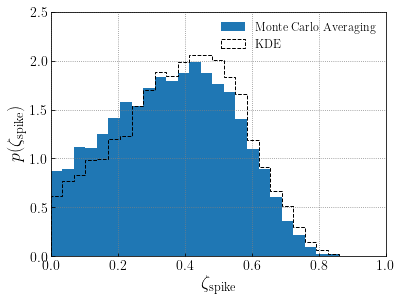

In [5]:
# Load inference results obtained using KDE'd likelihoods
kde_data = az.from_netcdf("effective_spin_gaussian_spike.cdf")
kde_stacked_samples = kde_data.posterior.stack(draws=("chain", "draw"))

# Set up figure
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot()
bins = np.linspace(0,1,30)

# Plot spike posterior
ax.hist(stacked_samples.zeta_spike.values,density=True,label='Monte Carlo Averaging',bins=bins)

# Plot posterior from KDE'd likelihods
ax.hist(kde_stacked_samples.zeta_spike.values,density=True,label='KDE',bins=bins,
        histtype='step',ls='--',color='black')

ax.set_xlim(0,1)
ax.set_ylim(0,2.5)
ax.set_xlabel(r'$\zeta_\mathrm{spike}$',fontsize=18)
ax.set_ylabel(r'$p(\zeta_\mathrm{spike})$',fontsize=18)
plt.legend(loc='upper right',frameon=False,fontsize=12)

plt.show()

Finally, let's make a "trace plot" showing the set of $\chi_\mathrm{eff}$ distributions corresponding to the above samples.

**CAUTION #1**: In order to actually visualize the zero-spin spike, we will plot this not as a delta function but as a Gaussian with a very small standard deviation.

**CAUTION #2**: The trace plot shown below is **generically misleading**. Due to the finite sampling of our posterior, combined with the fact that narrow Gaussians are intrininsically tall, in the trace plot it will always appear that a zero-spin spike is present, despite the fact that we measure $\zeta_\mathrm{spike}$ to be consistent with zero.

In [6]:
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

In [7]:
# Define a grid of effective spins
grid = np.linspace(-1,1,1000)

# Choose a number of traces to draw
nTraces = 500

# Instantiate an array to hold a collection of traces
p_chi = np.zeros((nTraces,grid.size))

# For a random set of posterior samples, compute and store the corresponding probability densities across our grid
random_indices = np.random.choice(np.arange(stacked_samples.mu_chi.size),size=nTraces,replace=False)
for i,ind in enumerate(random_indices):
    
    p_gaussian = gaussian(grid,stacked_samples.mu_chi.values[i],10.**stacked_samples.logsig_chi.values[i],-1,1)
    p_spike = gaussian(grid,0,0.001,-1,1)
    
    zeta_spike = stacked_samples.zeta_spike.values[i]
    p_chi[i,:] = zeta_spike*p_spike + (1.-zeta_spike)*p_gaussian

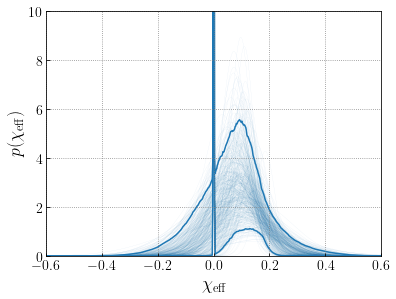

In [8]:
fig,ax = plt.subplots(figsize=(6,4.5))

# Plot individual traces
ax.plot(grid,p_chi.T,color='#1f78b4',lw=0.15,alpha=0.15,zorder=0)

# Also plot 5% and 95% credible bounds
ax.plot(grid,np.quantile(p_chi,0.05,axis=0),color='#1f78b4',zorder=1,label='Two-Component Mixture')
ax.plot(grid,np.quantile(p_chi,0.95,axis=0),color='#1f78b4',zorder=1)

ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,10)
ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

plt.show()